# Explore here

In [19]:
import numpy as np, random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import os
import os.path
import joblib


1)EDA: PREPARACION DE DATOS.

In [20]:
#CARGAMOS LOS DATOS.
df_rd= pd.read_csv('https://raw.githubusercontent.com/4GeeksAcademy/linear-regression-project-tutorial/main/medical_insurance_cost.csv')
df_rd.to_csv("/workspaces/EDALinRegJBG/data/raw/df_rd.csv", index=False)

In [21]:
#CHEQUEAMOS LOS DATOS. miramos caracteristicas del df.
print(df_rd.info())
#Modificaremos el dataframe sin duplicados.
#Borramos duplicados y nulos los pasamos a 0.
df_rd = df_rd.drop_duplicates().reset_index(drop = True)
df_rd = df_rd.fillna(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None


In [22]:
df_rd.head(7)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960


1)EVALUACION variable target columna numero 6(de 0 a 6) 'charges'.
Bajo varios varios criterios de evaluacion, nuestra variable target tiene un rango amplio de escala grande.

In [23]:
def vartype(df):
    num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    cat_cols = df.select_dtypes(include=['object']).columns.tolist()
    df_tipos = pd.DataFrame({'Tipo': ['Numérica']*len(num_cols) + ['Categórica']*len(cat_cols),
                            'Columna': num_cols + cat_cols})
    total_num = len(num_cols)
    total_cat = len(cat_cols)
    total_general = total_num + total_cat
    # Crear una lista de diccionarios para las nuevas filas
    new_rows = [{'Tipo': 'Total Numérico', 'Columna': total_num},
                {'Tipo': 'Total Categórico', 'Columna': total_cat},
                {'Tipo': 'Total General', 'Columna': total_general},]
    df_tipos = pd.concat([df_tipos, pd.DataFrame(new_rows)], ignore_index=True)
    return df_tipos
df_rd_vars= vartype(df_rd)
print(df_rd_vars)

               Tipo   Columna
0          Numérica       age
1          Numérica       bmi
2          Numérica  children
3          Numérica   charges
4        Categórica       sex
5        Categórica    smoker
6        Categórica    region
7    Total Numérico         4
8  Total Categórico         3
9     Total General         7


In [24]:
print(df_rd_vars[df_rd_vars['Tipo'] == 'Categórica']['Columna'].unique())

['sex' 'smoker' 'region']


In [25]:
def CatVarsDF(df, output_dir, index=False):
  cat_cols = df.select_dtypes(include=['object']).columns.tolist()
  df_cat = df[cat_cols]
  output_file = os.path.join(output_dir, 'df_cat.csv')
  df_cat.to_csv(output_file, index=index)
  return df_cat
CatVarsDF(df_rd,'/workspaces/EDALinRegJBG/data/processed/Dataframes/')
df_cat= pd.read_csv('/workspaces/EDALinRegJBG/data/processed/Dataframes/df_cat.csv')

In [26]:
#1)PREPARACION VARIABLES. CREAREMOS DOS DATAFRAMES CON Y SIN OUTLIERS.
#ADEMAS PARA USAR EL DF SIN OUTLIERS PARA EL ENTRENAMIENTO CON LA FUNCION SPLIT/TRAIN
#PODEMOS USAR LOS DATOS SOL PARA REPRESENTAR GRAFICOS DE DISTRIBUCION.
#REALIZAREMOS UNA FACTORIZACION DIRECTAMENTE, AUN ASI EL ANALISIS UNIVARIABLE CATEGORICO NO NOS LO SALTAREMOS.
from sklearn.preprocessing import LabelEncoder
import json
import os

def JsonFCZRename(df, categorical_cols, output_dir, suffix="_fc"):
    for col in categorical_cols:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        class_labels_str = [str(label) for label in le.classes_]
        mapping_dict = {str(value): str(index) for value, index in zip(class_labels_str, le.transform(class_labels_str))}
        print(f"Column: {col}")
        print(mapping_dict)
        filename = f"{col}_factors.json"
        filepath = os.path.join(output_dir, filename)
        with open(filepath, 'w') as f:
            json.dump(mapping_dict, f, indent=4)
        df.rename(columns={col: col + suffix}, inplace=True)
    return df
categorical_cols = ['sex', 'smoker', 'region']
JsonFCZRename(df_rd, categorical_cols, '/workspaces/EDALinRegJBG/data/processed/FcVarsJson/')

Column: sex
{'female': '0', 'male': '1'}
Column: smoker
{'no': '0', 'yes': '1'}
Column: region
{'northeast': '0', 'northwest': '1', 'southeast': '2', 'southwest': '3'}


,age,sex_fc,bmi,children,smoker_fc,region_fc,charges
0,19,0,27.900,0,1,3,16884.92400
1,18,1,33.770,1,0,2,1725.55230
2,28,1,33.000,3,0,2,4449.46200
3,33,1,22.705,0,0,1,21984.47061
4,32,1,28.880,0,0,1,3866.85520
...,...,...,...,...,...,...,...
1332,50,1,30.970,3,0,1,10600.54830
1333,18,0,31.920,0,0,0,2205.98080
1334,18,0,36.850,0,0,2,1629.83350
1335,21,0,25.800,0,0,3,2007.94500


In [27]:
#1)Bifurcar dataframe con y sin outliers(COl y SOl).
#dataframe sin outliers.
df_rd_sol= df_rd.copy()
df_rd_sol.to_csv('/workspaces/EDALinRegJBG/data/processed/Dataframes/df_rd_sol.csv')
#dataframe con outliers.
df_rd_col= df_rd.copy()
df_rd_col.to_csv('/workspaces/EDALinRegJBG/data/processed/Dataframes/df_rd_col.csv')


In [28]:
#1 Almacenamiento de OUTLIERS:
#TRAS OBSERVAR EL DF, NINGUNA DE LAS VARIABLES TIENE LOGICA QUE TENGA UN LOWER LIMIT
# NEGATIVO, AJUSTAMOS LA FUNCION PARA QUE LO MINIMO SEA 0
def LimsOlSaveJson(df, columns, output_path, lower_limit_zero=True):
    for column in columns:
        stats = df[column].describe()
        iqr = stats['75%'] - stats['25%']
        ul = stats['75%'] + (2 * iqr)
        ll = max(stats['25%'] - (2 * iqr), 0 if lower_limit_zero else None)
        limits = {"upper_limit": ul, "lower_limit": ll}
        file_path = f"{output_path}/limits_{column}.json"
        with open(file_path, "w") as f:
            json.dump(limits, f, indent=4)
        df[column] = df[column].apply(lambda x: ul if x > ul else ll if x < ll else x)
    return df
#hacemos una lista de todas las variables, como hemos factorizado todas las variables categoricas, todas deberian ser numericas.
num_vars= df_rd_sol.select_dtypes(include=np.number).columns.tolist()
LimsOlSaveJson(df_rd_sol, num_vars,'/workspaces/EDALinRegJBG/data/processed/')
df_rd_sol.describe()



,age,sex_fc,bmi,children,smoker_fc,region_fc,charges
count,1337.000000,1337.000000,1337.000000,1337.000000,1337.0,1337.000000,1337.000000
mean,39.222139,0.504862,30.661455,1.095737,0.0,1.516081,12970.771535
std,14.044333,0.500163,6.093403,1.205571,0.0,1.105208,11262.094971
min,18.000000,0.000000,15.960000,0.000000,0.0,0.000000,1121.873900
25%,27.000000,0.000000,26.290000,0.000000,0.0,1.000000,4746.344000
50%,39.000000,1.000000,30.400000,1.000000,0.0,2.000000,9386.161300
75%,51.000000,1.000000,34.700000,2.000000,0.0,2.000000,16657.717450
max,64.000000,1.000000,51.520000,5.000000,0.0,3.000000,40480.464350


2) ANALISIS UNIVARIABLE.


In [29]:
print(df_rd_vars)

               Tipo   Columna
0          Numérica       age
1          Numérica       bmi
2          Numérica  children
3          Numérica   charges
4        Categórica       sex
5        Categórica    smoker
6        Categórica    region
7    Total Numérico         4
8  Total Categórico         3
9     Total General         7


/tmp/ipykernel_767/2205171723.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab20', num_colors)
/tmp/ipykernel_767/2205171723.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=col, data=df, x=x_var, hue=hue_var if hue_var else None,
/tmp/ipykernel_767/2205171723.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=col, data=df, x=x_var, hue=hue_var if hue_var else None,
/tmp/ipykernel_767/2205171723.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is depre

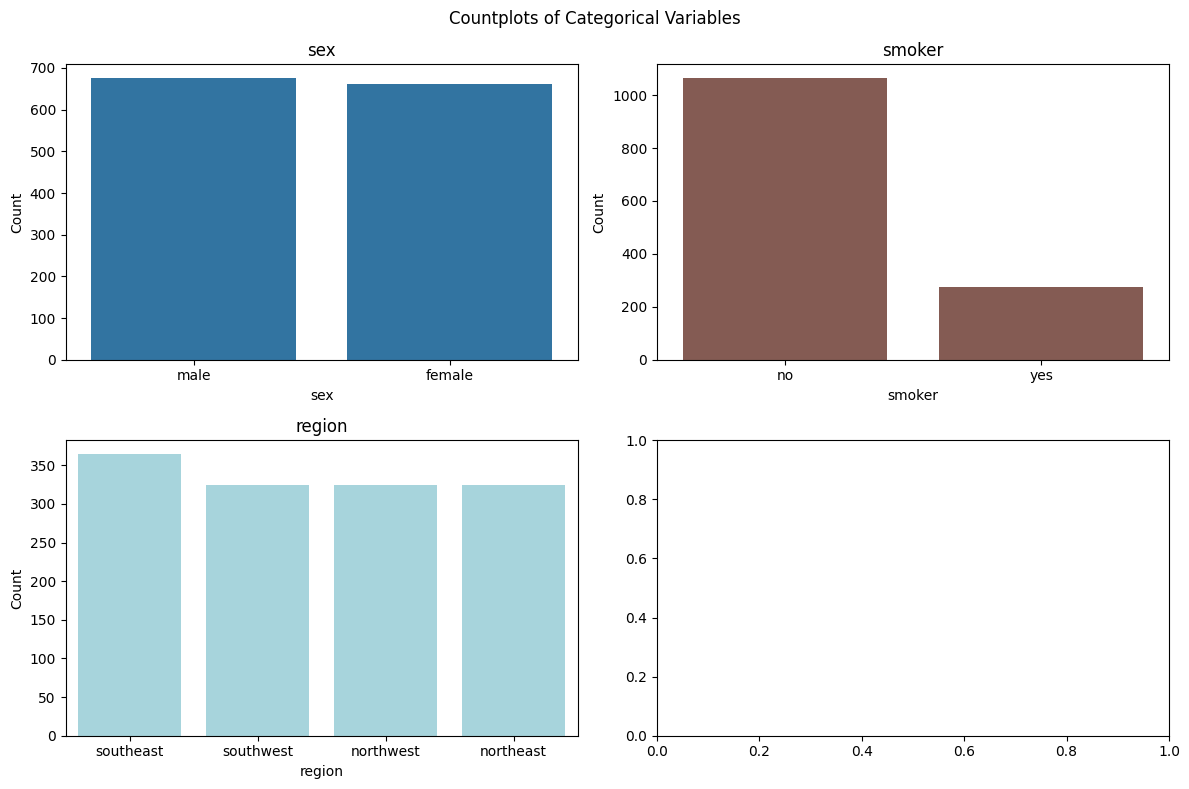

In [30]:
#2) ANÁLISIS CATEGORICAS UNIVARIABLE.
def GrafUniCat(df, x_vars, hue_var, nrows=2, ncols=2, figsize=(12, 8)):
  fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
  fig.suptitle("Countplots of Categorical Variables")
  num_colors = len(x_vars)
  cmap = plt.cm.get_cmap('tab20', num_colors)
  colors = cmap(range(num_colors))
  for i, row in enumerate(axs):
    for j, col in enumerate(row):
      if i * ncols + j >= len(x_vars):
        continue
      x_var = x_vars[i * ncols + j]
      sns.countplot(ax=col, data=df, x=x_var, hue=hue_var if hue_var else None,
                    order=df[x_var].sort_values().value_counts().index,
                    palette=[colors[i * ncols + j]] * df[x_var].nunique())
      col.set_title(x_var)
      col.set_xlabel(x_var)
      col.set_ylabel("Count")
  plt.tight_layout()
  plt.show()
x_vars = ["sex","smoker","region"] #lista de varcats
hue_var = None
GrafUniCat(df_cat, x_vars, hue_var, nrows=2, ncols=2) #rellenamos los input

Conclusion: La cantidad de muestras en género y región esta homogeneamente distribuida, en cambio los usuarios en porcentage, predominan aquellos que no fuman.

In [31]:
print(df_rd_vars[df_rd_vars['Tipo'] == 'Numérica']['Columna'].unique())

['age' 'bmi' 'children' 'charges']


/tmp/ipykernel_767/3398774513.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
/tmp/ipykernel_767/3398774513.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
/tmp/ipykernel_767/3398774513.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
/tmp/ipykernel_767/3398774513.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[row_index, col_index].set_xt

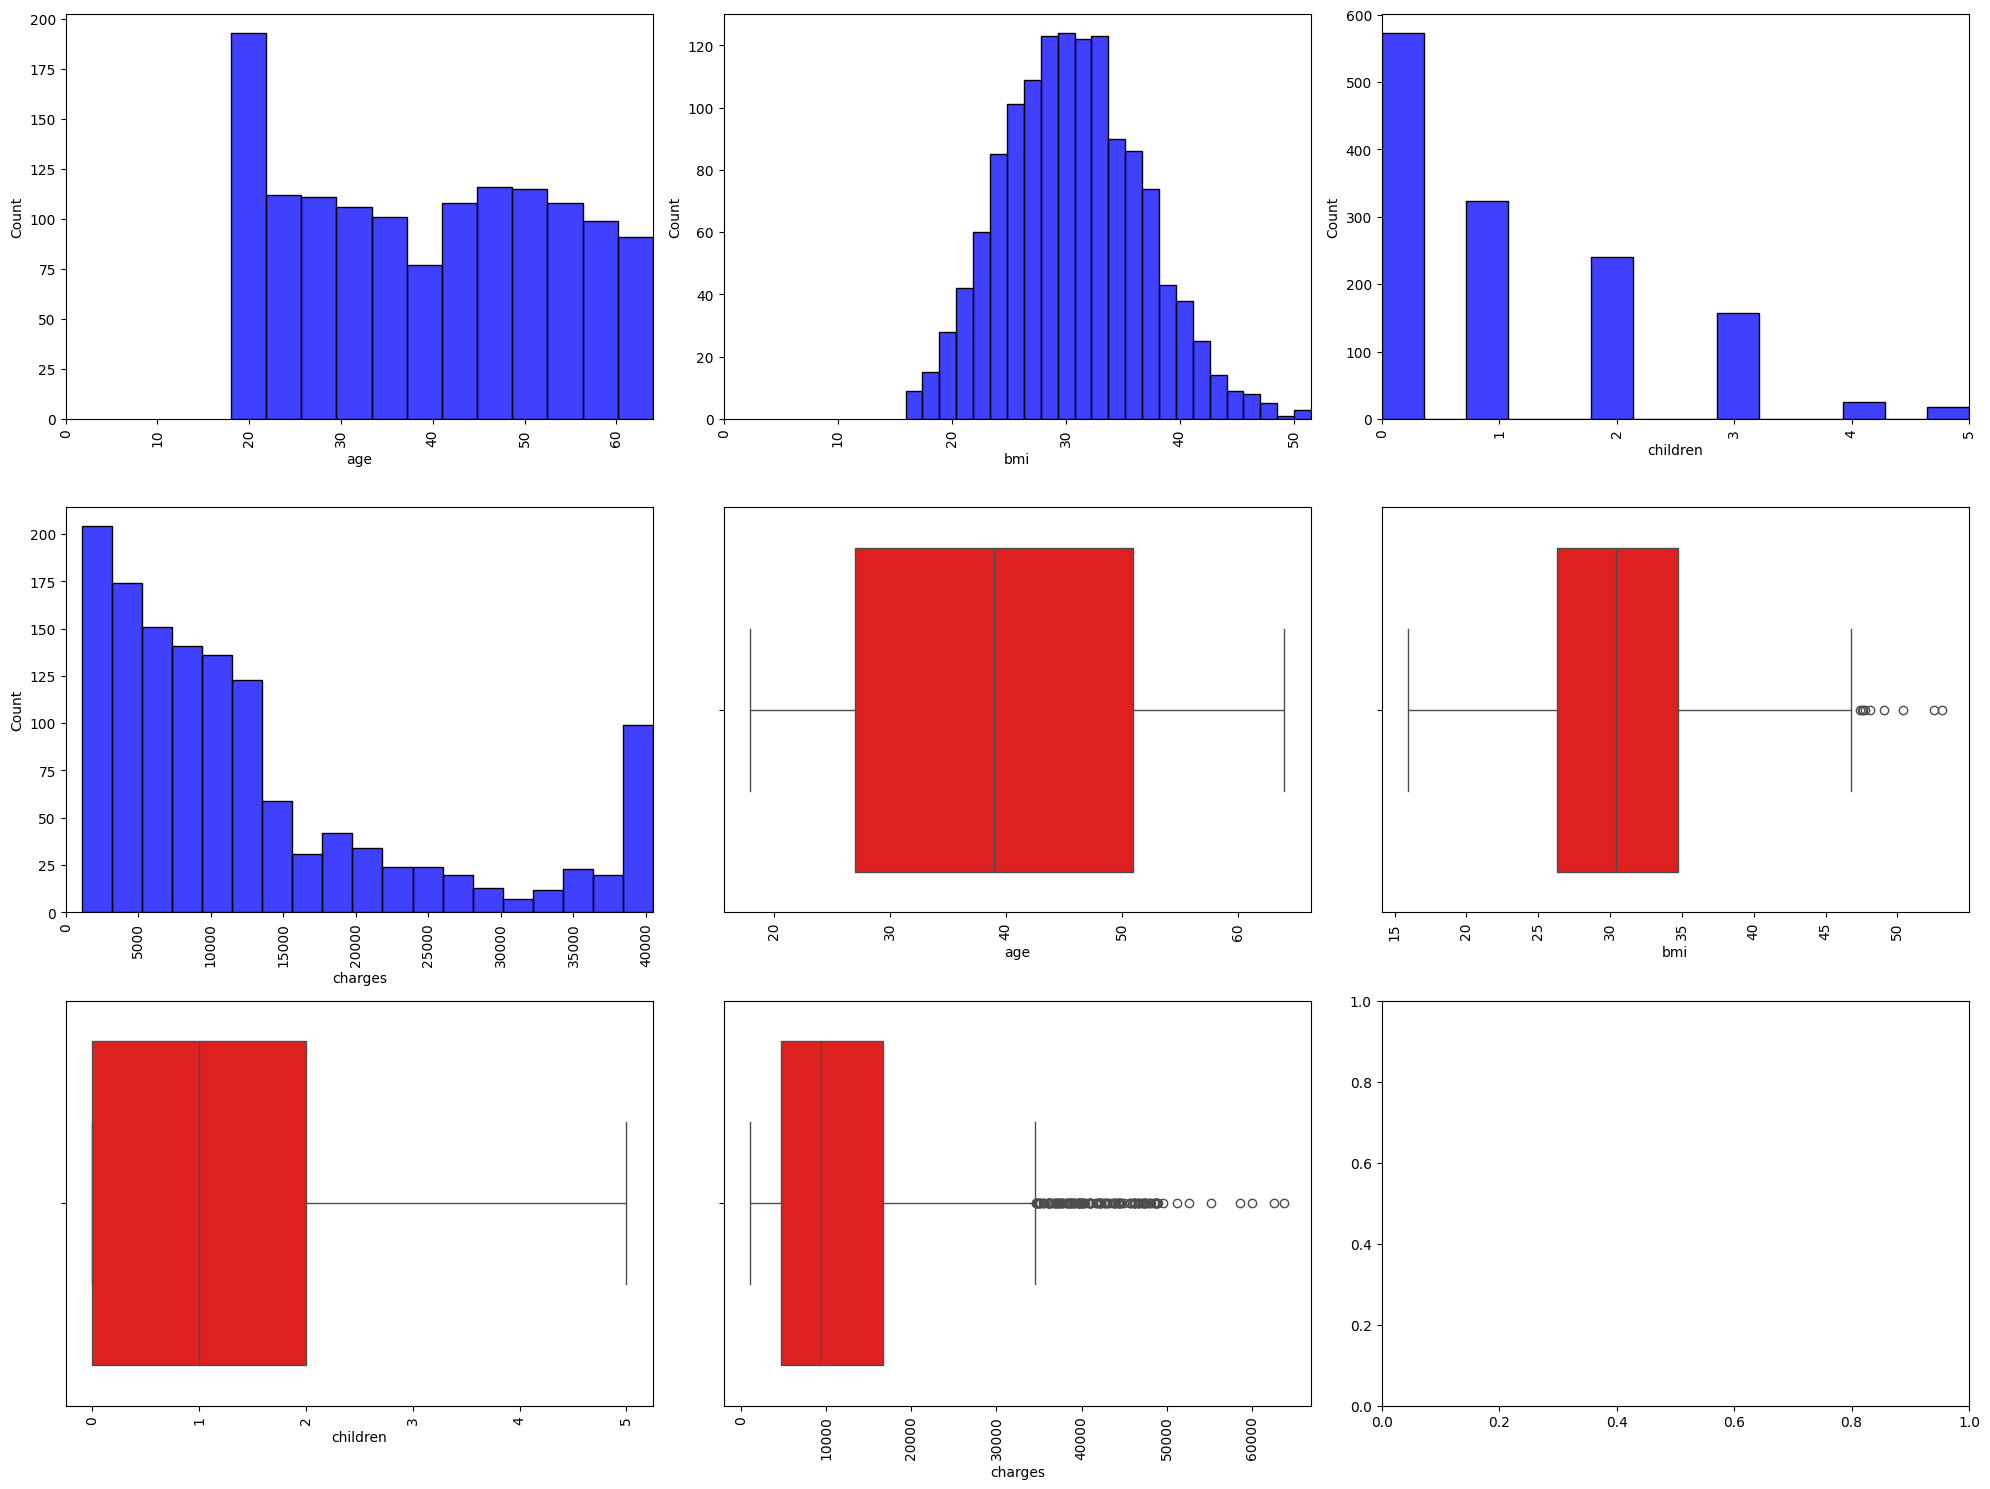

In [ ]:
#2)ANÁLISIS UNIVARIABLE, VARIABLES NUMÉRICAS.

import matplotlib.pyplot as plt
import seaborn as sns
import math

def GrafUniNum(df_no_outliers, df_with_outliers, hist_vars, box_vars):
  """
  Creamos un conjunto de graficos, los histogramas sin outliers para presenciar mejor la distribucion,
  los graficos de caja con outliers para visualizarlos.
  Args:
      df_no_outliers
      df_with_outliers
      hist_vars: lista de nombres de columnas.
      box_vars: lista de nombres de columnas.
  """

  num_hist_vars = len(hist_vars)  #Determinamos el numero de variables para el histograma sin Ol's
  num_box_vars = len(box_vars)  #Determinamos el numero de variables para los graficos de caga con Ol's
  total_vars = num_hist_vars + num_box_vars

  #Determinamos la cuadricula de graficos optima, evitando el zero
  if total_vars <= 4:
    row, col = 2, 2  
  elif total_vars <= 6:
    row, col = 2, 3  
  else:
    # Use a dynamic grid based on the number of variables (adjust as needed)
    row = math.ceil(total_vars / 3)
    col = 3
  fig, axs = plt.subplots(row, col, figsize=(20, 5 * row))
  i = 0
  for var in hist_vars:
    row_index = i // col
    col_index = i % col
    sns.histplot(ax=axs[row_index, col_index], data=df_no_outliers, x=var, color="blue")
    max_val_no_outliers = df_no_outliers[var].max()
    axs[row_index, col_index].set_xlim(0, max_val_no_outliers)
    axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
    i += 1
  for var in box_vars:
    row_index = i // col
    col_index = i % col
    sns.boxplot(ax=axs[row_index, col_index], data=df_with_outliers, x=var, color="red")
    axs[row_index, col_index].set_xticklabels(axs[row_index, col_index].get_xticklabels(), rotation=90)
    i += 1
  plt.tight_layout()
  plt.show()
#Preparamos la llamada a la funcion y el input
hist_vars = ['age', 'bmi', 'children', 'charges']
box_vars = ['age', 'bmi', 'children', 'charges']
GrafUniNum(df_rd_sol, df_rd_col, hist_vars, box_vars)


Conclusiones: 
-La variable numerica de "Age" nos indica que los usuarios se distribuien homogeneamente en un rango comprendido entre 20 y 60 años aproximadamente(Distribucion lineal).
-La variable BMI , gracias al grafico histograma sin outliers se observa una distribucion simetrica normal, aunque si que es cierto que tiene ciertas muestras con outliers sobre el rango maximo del 75%Q no sera un problema.
-Tanto la variable "children" y "charges" tienen una distrbucion asimetrica con grado de libertad, mientras que children tiene el max definido, en charges existen muestras fuera del rango maximo de la distribucion(Ol's).
Sin ver el mapa de calor creo que estas dos variables tienen cierta correlacion.
Optare por standarizar los valores, ya que hay pocas variables con outliers y poco % de muestras, escalar mediante la media y el STD sera una buena idea.